# Lab 4 - Linear models

We focus on models in the form 

$$ y \sim \mathrm{Normal}(\alpha+X\beta,\sigma) $$



In [1]:
from cmdstanpy import CmdStanModel


import arviz as az
import numpy as np
import scipy.stats as stats

import matplotlib.pyplot as plt
import pandas as pd

/usr/local/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Excercise 1 - modelling height of !Kung people

### Normal model - no predictors
We will try to fit $\mathrm{Normal}(\mu,\sigma)$ distribution to height data. Special case of linear model with $\beta=0$.

In [2]:
_BASE_URL = "https://raw.githubusercontent.com/rmcelreath/rethinking/Experimental/data"
HOWELL_DATASET_PATH = f"{_BASE_URL}/Howell1.csv"
d = pd.read_csv(HOWELL_DATASET_PATH, sep=';', header=0)
d=d[d.age>=18] #just adults 
d.head()

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041914,41.0,1
4,145.415,41.276872,51.0,0


In [3]:
d.describe()

,height,weight,age,male
count,352.000000,352.000000,352.000000,352.000000
mean,154.597093,44.990486,41.138494,0.468750
std,7.742332,6.456708,15.967855,0.499733
min,136.525000,31.071052,18.000000,0.000000
25%,148.590000,40.256290,28.000000,0.000000
50%,154.305000,44.792210,39.000000,0.000000
75%,160.655000,49.292693,51.000000,1.000000
max,179.070000,62.992589,88.000000,1.000000


In [4]:
%%writefile height_1_ppc.stan

generated quantities {
  real u = normal_rng(154, 7.7);
  real sigma = normal_rng(15, 3);
  real height = normal_rng(u, sigma);
}

Overwriting height_1_ppc.stan


In [5]:
import seaborn as sns

## Task 1. Prior predictive checks

In [6]:
model_ppc=CmdStanModel(stan_file='height_1_ppc.stan')

R = 1000
sim=model_ppc.sample(iter_sampling=R,
                     iter_warmup=0,
                     chains=1,
                     fixed_param=True,
                     seed=29042020,refresh=R)

INFO:cmdstanpy:compiling stan file /home/height_1_ppc.stan to exe file /home/height_1_ppc
INFO:cmdstanpy:compiled model executable: /home/height_1_ppc
INFO:cmdstanpy:CmdStan start processing
chain 1 |█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


In [7]:
sim_df = sim.draws_pd()
sim_df.head()

,lp__,accept_stat__,u,sigma,height
0,0.0,0.0,174.853,17.3315,152.803
1,0.0,0.0,154.982,10.8317,157.649
2,0.0,0.0,163.230,21.7960,184.391
3,0.0,0.0,158.276,16.7968,157.906
4,0.0,0.0,164.103,13.9736,159.755


In [8]:
sim_df.mean()

lp__               0.000000
accept_stat__      0.000000
u                154.295303
sigma             14.945527
height           155.377509
dtype: float64



1. Plot histograms of mu, sigma and simulated height.
2. Plot a joint distribution of mu and sigma.
3. Check if samples are consistent with priors.
4. Correct prior parameters to make them reasonably spreaded out. 
5. Check if observed data is possible to obtain using priors.

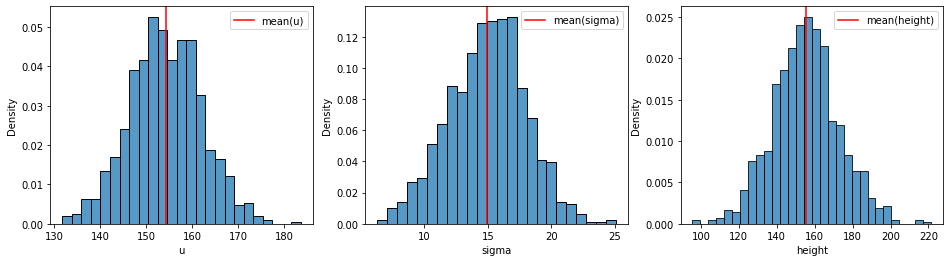

In [9]:
fig, ax = plt.subplots(1, 3, figsize=(16, 4))
sns.histplot(data=sim_df, stat='density', x='u', ax=ax[0])
ax[0].axvline(x=sim_df.u.mean(), color='r', label='mean(u)')
sns.histplot(data=sim_df, stat='density', x='sigma', ax=ax[1])
ax[1].axvline(x=sim_df.sigma.mean(), color='r', label='mean(sigma)')
sns.histplot(data=sim_df, stat='density', x='height', ax=ax[2])
ax[2].axvline(x=sim_df.height.mean(), color='r', label='mean(height)')
for a in ax:
    a.legend()
plt.show()

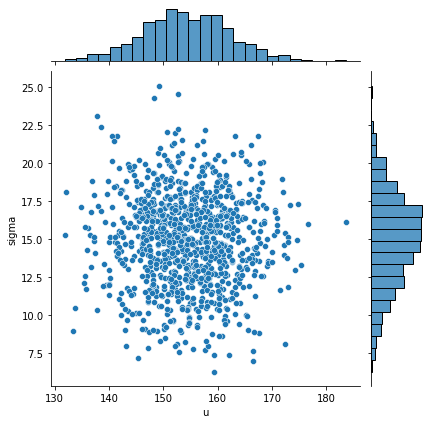

In [10]:
sns.jointplot(data=sim_df, x='u', y='sigma')

The samples appear to be consistent with the priors. The summary statistics such as mean and standard deviation are similiar and the distributions also resemble one another.

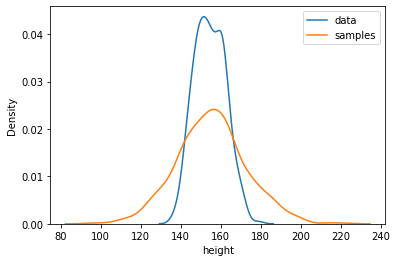

In [11]:
sns.kdeplot(data=d, x='height', label="data")
sns.kdeplot(data=sim_df, x='height', label="samples")
plt.legend()
plt.show()

LGTM. It's quite good if we take into account the measurement errors.

## Task 2. Model fit and evaluation

In [12]:
%%writefile height_1_fit.stan

data {
    int<lower=0> N;
    vector[N] heights;
}

parameters {
    real<lower=0> mean;
    real<lower=0> sigma;
}

model {
    mean ~ normal(154, 7.7);
    sigma ~ normal(15, 3);
    
    heights ~ normal(mean, sigma);
}

generated quantities {
    real h_hat = normal_rng(mean, sigma);
}

Overwriting height_1_fit.stan


In [13]:
model_1_fit=CmdStanModel(stan_file='height_1_fit.stan')

INFO:cmdstanpy:compiling stan file /home/height_1_fit.stan to exe file /home/height_1_fit
INFO:cmdstanpy:compiled model executable: /home/height_1_fit


In [14]:
fit=model_1_fit.sample(data=dict(N=len(d),heights=d.height.values),
                         seed=28052020)

INFO:cmdstanpy:CmdStan start processing
chain 1 |                                                                                                                                                                                     | 00:00 Status
chain 2 |                                                                                                                                                                                     | 00:00 Status

chain 3 |                                                                                                                                                                                     | 00:00 Status


chain 1 |████████▏                                                                                                                                                                            | 00:00 Status
chain 2 |████████▏                                                                                                                       

INFO:cmdstanpy:CmdStan done processing.


In [15]:
df = fit.draws_pd()
df.head()

,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,mean,sigma,h_hat
0,-891.998,1.000000,0.665583,2.0,3.0,0.0,894.148,154.840,7.70316,160.704
1,-891.755,0.996987,0.665583,2.0,3.0,0.0,892.028,154.622,7.81191,153.950
2,-891.816,0.871319,0.665583,2.0,3.0,0.0,892.666,154.606,7.70830,167.189
3,-896.723,0.669702,0.665583,2.0,3.0,0.0,897.053,154.923,6.99096,156.110
4,-895.051,1.000000,0.665583,2.0,3.0,0.0,897.129,155.113,7.20423,154.452



1. Plot a joint distribution of fitted mu and sigma.
2. Plot histograms of data and simulated heights and evaluate the quality of model.


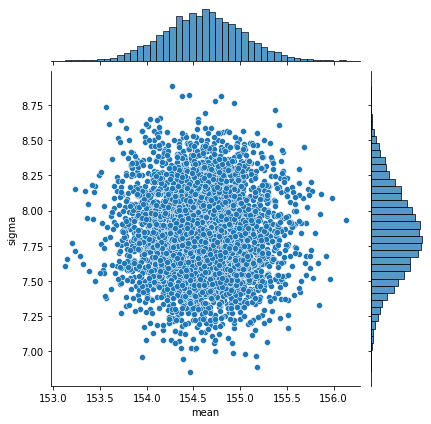

In [16]:
sns.jointplot(data=df, x='mean', y='sigma')

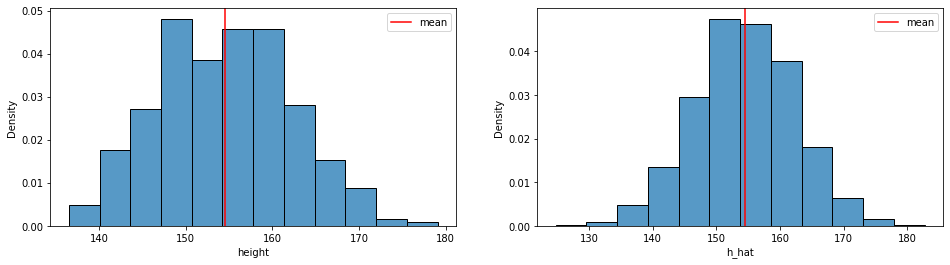

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(16, 4))
sns.histplot(data=d, stat='density', x='height', ax=ax[0], bins=12)
ax[0].axvline(x=d.height.mean(), color='r', label='mean')
sns.histplot(data=df, stat='density', x='h_hat', ax=ax[1], bins=12)
ax[1].axvline(x=df.h_hat.mean(), color='r', label='mean')
for a in ax:
    a.legend()
plt.show()

## Task 3. Adding predictor to the model - weight

Create column ```c_weight``` in the dataframe containing weights substrated by their mean.


In [18]:
d['c_weight'] = d['weight'] - d['weight'].mean()

In [19]:
data_sim={'N':50, 'weight':np.linspace(d.c_weight.min(),d.c_weight.max())}

## Task 4. Prior predictive checks
 

In [20]:
%%writefile height_2a_ppc.stan
data {
  int<lower=0> N;
  vector[N] weight;
}

generated quantities {
  real alpha = normal_rng(154, 7.7);
  real beta = normal_rng(0, 1);
  real sigma = normal_rng(15, 3);
  vector[N] height;

  for (i in 1:N) {
    height[i] = normal_rng(alpha + beta * weight[i], sigma);
  }
}


Overwriting height_2a_ppc.stan


In [21]:
model_ppc=CmdStanModel(stan_file='height_2a_ppc.stan')
R = 1000
sim=model_ppc.sample(data=data_sim,
                     iter_sampling=R, 
                     iter_warmup=0, 
                     chains=1, 
                     refresh=R,
                     fixed_param=True,
                     seed=29042020)

INFO:cmdstanpy:compiling stan file /home/height_2a_ppc.stan to exe file /home/height_2a_ppc
INFO:cmdstanpy:compiled model executable: /home/height_2a_ppc
INFO:cmdstanpy:CmdStan start processing
chain 1 |█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


Plot lines for each sampled slope beta and intercept alpha, verify if possible predicted heights are consistent with minimum (0) and maximum (check Wikipedia) heights observed in nature.

In [22]:
ppc_df = sim.draws_pd()
ppc_df.head()

,lp__,accept_stat__,alpha,beta,sigma,height[1],height[2],height[3],height[4],height[5],...,height[41],height[42],height[43],height[44],height[45],height[46],height[47],height[48],height[49],height[50]
0,0.0,0.0,174.853,0.777181,11.1832,165.4620,149.003,167.800,178.960,191.394,...,197.290,205.850,202.516,188.713,170.851,180.796,184.281,196.372,191.528,196.042
1,0.0,0.0,144.768,-0.006780,14.9889,163.0720,156.243,155.941,162.508,163.030,...,184.752,144.316,131.185,142.322,130.389,152.391,129.053,143.160,164.202,143.509
2,0.0,0.0,150.712,-1.138640,11.3344,182.6160,163.686,163.261,171.195,168.059,...,156.712,121.125,152.559,138.475,156.119,133.294,143.718,136.787,130.504,132.634
3,0.0,0.0,146.438,-0.254452,13.4763,167.8900,140.922,146.712,136.634,146.343,...,150.876,145.270,148.297,162.189,136.760,136.061,154.384,135.735,147.490,137.054
4,0.0,0.0,146.351,1.671020,12.8918,89.4398,116.555,115.162,116.381,144.133,...,186.902,184.623,159.391,172.202,169.217,166.266,166.319,184.026,182.761,165.941


In [23]:
alpha = ppc_df['alpha'].values
beta = ppc_df['beta'].values
weight = np.linspace(d.c_weight.min(),d.c_weight.max(), R).reshape((R, 1))
h_hat = weight * beta + alpha

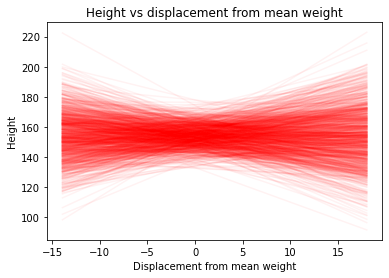

In [24]:
extended_domain = np.ones((1, R)) * weight
plt.plot(extended_domain, h_hat, 'r', alpha=0.05)
plt.title('Height vs displacement from mean weight')
plt.xlabel('Displacement from mean weight')
plt.ylabel('Height')
plt.show()

In [25]:
heights = ppc_df.loc[:, 'height[1]':'height[50]'].values

In [26]:
heights.mean()

154.136698042

In [27]:
heights.std()

19.631914757250748

In [28]:
heights.min()

58.7084

In [29]:
heights.max()

246.371

Summary statistics appear to be correct. The maximum height of a human is 278 cm

## Task 5. Modifying prior

If prior for beta admits negative values, then it makes no sense. Lets change prior to lognormal distribution.


In [30]:
%%writefile height_2b_ppc.stan

data {
  int<lower=0> N;
  vector[N] weight;
}

generated quantities {
  real alpha = normal_rng(154, 7.7);
  real beta = lognormal_rng(0, 1);
  real sigma = normal_rng(15, 3);
  vector[N] height;

  for (i in 1:N) {
    height[i] = normal_rng(alpha + beta * weight[i], sigma);
  }
}

Overwriting height_2b_ppc.stan


In [31]:
model_ppc=CmdStanModel(stan_file='height_2b_ppc.stan')

INFO:cmdstanpy:compiling stan file /home/height_2b_ppc.stan to exe file /home/height_2b_ppc
INFO:cmdstanpy:compiled model executable: /home/height_2b_ppc


In [32]:
sim=model_ppc.sample(data=data_sim, 
                     iter_sampling=R, 
                     iter_warmup=0, 
                     chains=1, 
                     refresh=R,
                     fixed_param=True,
                     seed=29042020)

INFO:cmdstanpy:CmdStan start processing
chain 1 |█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


In [33]:
ppc_df = sim.draws_pd()
ppc_df.head()

,lp__,accept_stat__,alpha,beta,sigma,height[1],height[2],height[3],height[4],height[5],...,height[41],height[42],height[43],height[44],height[45],height[46],height[47],height[48],height[49],height[50]
0,0.0,0.0,174.853,2.175330,11.1832,146.0000,130.4530,150.1610,162.2310,175.576,...,214.263,223.733,221.309,208.417,191.467,202.322,206.719,219.720,215.787,221.211
1,0.0,0.0,144.768,0.993243,14.9889,149.1520,142.9750,143.3240,150.5430,151.716,...,196.891,157.106,144.627,156.416,145.134,167.787,145.101,159.859,181.553,161.511
2,0.0,0.0,150.712,0.320255,11.3344,162.3100,144.3300,144.8550,153.7390,151.554,...,174.421,139.785,172.170,159.036,177.630,155.755,167.130,161.150,155.817,158.897
3,0.0,0.0,146.438,0.775342,13.4763,153.5560,127.2590,133.7200,124.3120,134.692,...,163.377,158.442,162.140,176.703,151.944,151.916,170.910,152.932,165.357,155.593
4,0.0,0.0,146.351,5.317560,12.8918,38.6819,68.1728,69.1555,72.7499,102.878,...,231.168,231.264,208.407,223.594,222.984,222.409,224.838,244.921,246.031,231.587


1. Plot lines for each sampled slope beta and intercept alpha, verify if possible predicted heights are consistent with minimum (0) and maximum (check Wikipedia) heights observed in nature.
2. For each simulated weight plot maximum, minimum, and 5, 25, 50, 75, 95 quantiles of simulated weight (all in the same plot). Compare with observed data. Is observed data possible within the prior model?

In [34]:
alpha = ppc_df['alpha'].values
beta = ppc_df['beta'].values
h_hat = weight * beta + alpha

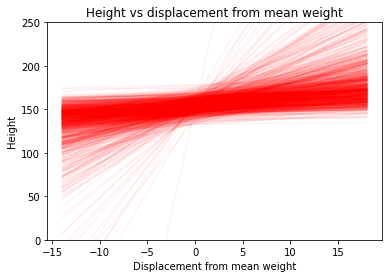

In [35]:
plt.plot(extended_domain, h_hat, 'r', alpha=0.05)
plt.title('Height vs displacement from mean weight')
plt.xlabel('Displacement from mean weight')
plt.ylim([0, 250])
plt.ylabel('Height')
plt.show()

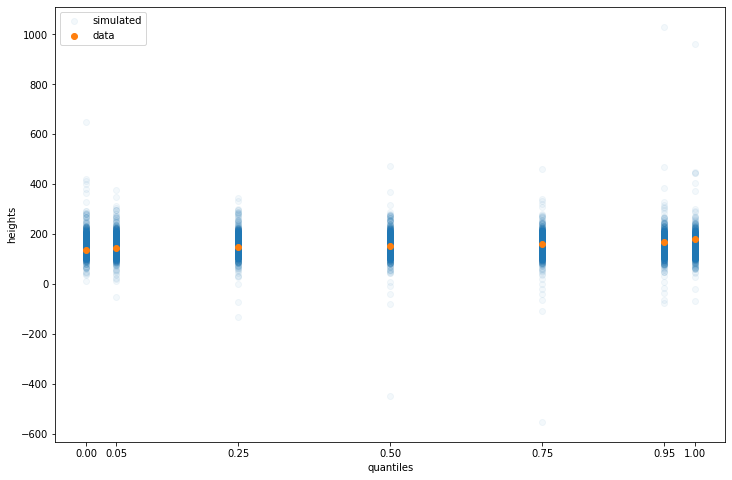

In [36]:
heights = ppc_df.loc[:, 'height[1]':'height[50]'].values
q = [0., 0.05, 0.25, 0.5, 0.75, 0.95, 1.]
quantiles = np.quantile(heights, q, axis=1)
data_quantiles = np.quantile(d.height, q)

plt.figure(figsize=(12, 8))
plt.scatter(q * np.ones((1000, 1)), quantiles, alpha=0.05, label='simulated')
plt.scatter(q, data_quantiles, label='data')
plt.xticks(q)
plt.xlabel('quantiles')
plt.ylabel('heights')
plt.legend()
plt.show()

Observed data is possible within the prior model, but the prior model covers a broader range of possibilities.

## Task 6. Fitting and evaluating model


In [37]:
%%writefile height_2_fit.stan

data {
    int<lower=0> N;
    vector[N] heights;
    vector[N] weights;
}

parameters {
    real<lower=0> alpha;
    real<lower=0> sigma;
    real<lower=0> beta;
}

transformed parameters {
    vector[N] mean;
    for (i in 1:N) {
      mean[i] = alpha + beta * weights[i];
  }
}

model {
    alpha ~ normal(154, 7.7);
    sigma ~ normal(15, 3);
    beta ~ lognormal(0, 1);
    
    for (i in 1:N) {
      heights[i] ~ normal(mean[i], sigma);
    }
}

generated quantities {
    vector[N] h_hat;
    for (i in 1:N) {
        h_hat[i] = normal_rng(mean[i], sigma);
    }
}

Overwriting height_2_fit.stan


In [38]:
model_2_fit=CmdStanModel(stan_file='height_2_fit.stan')

INFO:cmdstanpy:compiling stan file /home/height_2_fit.stan to exe file /home/height_2_fit
INFO:cmdstanpy:compiled model executable: /home/height_2_fit


1. Create ```data_fit``` dictionary containing data from  ```N``` first rows of dataframe


In [39]:
N = 100
data_fit = {'N': N, 'weights': d.weight.values[:N], 'heights': d.height.values[:N]}

In [40]:
fit=model_2_fit.sample(data=data_fit,seed=28052020)


INFO:cmdstanpy:CmdStan start processing
chain 1 |                                                                                                                                                                                     | 00:00 Status
chain 2 |                                                                                                                                                                                     | 00:00 Status

chain 3 |                                                                                                                                                                                     | 00:00 Status


chain 1 |████████▏                                                                                                                                                                            | 00:00 Status
chain 2 |████████▏                                                                                                                       

chain 4 |██████████████████████████████████████████████████████████████████████████                                                                          | 00:02 Iteration:  900 / 2000 [ 45%]  (Warmup)
chain 1 |██████████████████████████████████████████████████████████████████████████████████████▎                                                           | 00:03 Iteration: 1001 / 2000 [ 50%]  (Sampling)

chain 3 |██████████████████████████████████████████████████████████████████████████████████████▎                                                           | 00:03 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 4 |██████████████████████████████████████████████████████████████████████████████████████▎                                                           | 00:03 Iteration: 1001 / 2000 [ 50%]  (Sampling)
chain 1 |████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 00:03 Iteration: 110

INFO:cmdstanpy:CmdStan done processing.


2. Plot lines for each sampled slope beta and intercept alpha. Verify how uncertainity changes with increasing of sample (N)
2. For each value of weight plot mean simulated height along with errorbar of one standard deviation (use ```errorbar``` from matplotlib). Compare with observed data (N points). Is observed data possible within the posterior model? What changes when N increases.


In [41]:
df = fit.draws_pd()
df.head()

,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,alpha,sigma,beta,...,h_hat[91],h_hat[92],h_hat[93],h_hat[94],h_hat[95],h_hat[96],h_hat[97],h_hat[98],h_hat[99],h_hat[100]
0,-231.901,0.984928,0.108414,5.0,43.0,0.0,232.502,118.684,6.27806,0.795357,...,160.752,163.397,153.231,154.290,162.605,163.748,153.677,174.541,163.442,159.503
1,-233.760,0.995098,0.108414,4.0,15.0,0.0,234.005,119.677,6.88797,0.775776,...,160.881,161.327,144.210,163.015,145.309,161.866,145.617,162.611,151.403,155.038
2,-234.940,0.760257,0.108414,2.0,7.0,0.0,237.469,118.947,6.63518,0.754682,...,163.625,152.688,146.212,148.252,148.719,151.755,151.233,147.579,157.769,152.037
3,-233.559,0.947589,0.108414,2.0,3.0,0.0,235.873,118.949,6.58363,0.765099,...,165.092,156.128,148.777,162.442,143.534,153.526,145.762,163.472,158.453,148.620
4,-233.383,0.985758,0.108414,5.0,63.0,0.0,235.413,115.522,6.44875,0.848533,...,165.032,166.198,147.014,148.215,145.679,173.449,163.958,152.710,161.118,143.945


In [42]:
df.describe()

,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,alpha,sigma,beta,...,h_hat[91],h_hat[92],h_hat[93],h_hat[94],h_hat[95],h_hat[96],h_hat[97],h_hat[98],h_hat[99],h_hat[100]
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.0,4000.000000,4000.000000,4000.000000,4000.000000,...,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,-232.669390,0.931401,0.110990,3.835000,22.912000,0.0,234.158797,119.851089,5.900383,0.764705,...,160.657688,159.975636,152.250330,157.748906,151.713457,162.492701,151.940871,160.446379,158.331883,152.456247
std,1.217811,0.101700,0.003294,1.138463,13.843271,0.0,1.710898,3.650302,0.464438,0.079908,...,6.074571,5.962046,6.031515,6.013037,5.990198,5.945925,5.797413,6.060914,6.035395,5.891681
min,-240.697000,0.098910,0.107576,1.000000,1.000000,0.0,231.298000,104.430000,4.720220,0.487793,...,142.545000,138.790000,131.625000,135.546000,130.531000,141.056000,128.843000,135.354000,139.568000,132.432000
25%,-233.246000,0.907331,0.108204,3.000000,15.000000,0.0,232.908750,117.441000,5.580840,0.713200,...,156.591750,156.066000,148.161000,153.611000,147.574750,158.511250,148.138750,156.231750,154.132000,148.493500
50%,-232.361500,0.975162,0.110254,4.000000,23.000000,0.0,233.831500,119.732000,5.881645,0.766544,...,160.684500,159.994500,152.483500,157.780000,151.762500,162.585500,151.997500,160.378500,158.431000,152.489500
75%,-231.774750,0.995815,0.113039,5.000000,31.000000,0.0,235.085250,122.184000,6.197342,0.817843,...,164.664250,163.923000,156.270000,161.749500,155.758750,166.552500,155.794500,164.568750,162.515000,156.401250
max,-231.146000,1.000000,0.115876,6.000000,63.000000,0.0,245.909000,132.986000,7.717820,1.103940,...,181.263000,180.444000,174.868000,180.573000,172.302000,182.076000,176.560000,183.235000,181.233000,173.591000


In [43]:
heights = df.loc[:, 'h_hat[1]':f'h_hat[{N}]'].values

In [55]:
heights.min()

122.2

In [45]:
heights.max()

193.901

In [50]:
alpha = df['alpha'].values
beta = df['beta'].values

In [51]:
alpha.shape

(4000,)

In [52]:
weight_range = np.linspace(data_fit['weights'].min(), data_fit['weights'].max(), N).reshape((N, 1))

hhat = beta * weight_range + alpha
hhat.max()

174.36803870066

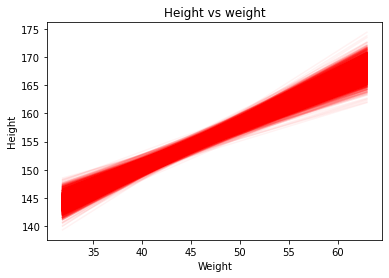

In [54]:
extended_domain = np.ones((1, 4000)) * weight_range
plt.plot(extended_domain, hhat, 'r', alpha=0.05)
plt.title('Height vs weight')
plt.xlabel('Weight')
plt.ylabel('Height')
plt.show()

INFO:cmdstanpy:CmdStan start processing
chain 1 |                                                                                                                                                                                     | 00:00 Status
chain 2 |                                                                                                                                                                                     | 00:00 Status

chain 3 |                                                                                                                                                                                     | 00:00 Status


chain 1 |████████▏                                                                                                                                                                            | 00:00 Status
chain 2 |████████▏                                                                                                                       

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:CmdStan start processing
chain 1 |                                                                                                                                                                                     | 00:00 Status
chain 2 |                                                                                                                                                                                     | 00:00 Status

chain 3 |                                                                                                                                                                                     | 00:00 Status


chain 1 |████████▏                                                                                                                                                                            | 00:00 Status
chain 2 |████████▏                                                                                                                       

chain 1 |██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 00:02 Iteration: 1600 / 2000 [ 80%]  (Sampling)


chain 4 |███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 00:02 Iteration: 1800 / 2000 [ 90%]  (Sampling)
chain 2 |███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 00:02 Iteration: 1500 / 2000 [ 75%]  (Sampling)

chain 3 |██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 00:02 Iteration: 1600 / 2000 [ 80%]  (Sampling)

chain 1 |███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 00:02 Iteration: 18


INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:CmdStan start processing
chain 1 |                                                                                                                                                                                     | 00:00 Status
chain 2 |                                                                                                                                                                                     | 00:00 Status

chain 3 |                                                                                                                                                                                     | 00:00 Status


chain 1 |████████▏                                                                                                                                                                            | 00:00 Status
chain 2 |████████▏                                                                                                                       

chain 2 |██████████████████████████████████████████████████████████████████████████████████████▎                                                           | 00:01 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 4 |██████████████████████████████████████████████████████████████████████████████████████▎                                                           | 00:01 Iteration: 1001 / 2000 [ 50%]  (Sampling)

chain 1 |████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 00:01 Iteration: 1100 / 2000 [ 55%]  (Sampling)
chain 2 |████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 00:02 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 4 |████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 00:02 Iteration: 1

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:CmdStan start processing
chain 1 |                                                                                                                                                                                     | 00:00 Status
chain 2 |                                                                                                                                                                                     | 00:00 Status

chain 3 |                                                                                                                                                                                     | 00:00 Status


chain 1 |████████▏                                                                                                                                                                            | 00:00 Status

chain 3 |████████▏                                                                                                                      

chain 4 |██████████████████████████████████████████████████████████████████████████                                                                          | 00:02 Iteration:  900 / 2000 [ 45%]  (Warmup)
chain 2 |██████████████████████████████████████████████████████████████████████████████████████▎                                                           | 00:02 Iteration: 1001 / 2000 [ 50%]  (Sampling)

chain 1 |████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 00:02 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 4 |██████████████████████████████████████████████████████████████████████████████████████▎                                                           | 00:02 Iteration: 1001 / 2000 [ 50%]  (Sampling)
chain 1 |███████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 00:02 Iteration: 120

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:CmdStan start processing
chain 1 |                                                                                                                                                                                     | 00:00 Status
chain 2 |                                                                                                                                                                                     | 00:00 Status

chain 3 |                                                                                                                                                                                     | 00:00 Status


chain 1 |████████▏                                                                                                                                                                            | 00:00 Status
chain 2 |████████▏                                                                                                                       

chain 2 |██████████████████████████████████████████████████████████████████████████████████████▎                                                           | 00:03 Iteration: 1001 / 2000 [ 50%]  (Sampling)

chain 1 |██████████████████████████████████████████████████████████████████████████████████████▎                                                           | 00:03 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 4 |██████████████████████████████████████████████████████████████████████████████████████▎                                                           | 00:03 Iteration: 1001 / 2000 [ 50%]  (Sampling)
chain 2 |████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 00:03 Iteration: 1100 / 2000 [ 55%]  (Sampling)

chain 1 |████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 00:03 Iteration: 11


INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:CmdStan start processing
chain 1 |                                                                                                                                                                                     | 00:00 Status
chain 2 |                                                                                                                                                                                     | 00:00 Status

chain 3 |                                                                                                                                                                                     | 00:00 Status


chain 1 |████████▏                                                                                                                                                                            | 00:00 Status
chain 2 |████████▏                                                                                                                       

chain 2 |██████████████████████████████████████████████████████████████████████████████████████▎                                                           | 00:06 Iteration: 1001 / 2000 [ 50%]  (Sampling)

chain 3 |██████████████████████████████████████████████████████████████████████████                                                                          | 00:06 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |██████████████████████████████████████████████████████████████████████████████████████▎                                                           | 00:07 Iteration: 1001 / 2000 [ 50%]  (Sampling)
chain 2 |████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 00:07 Iteration: 1100 / 2000 [ 55%]  (Sampling)

chain 1 |████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 00:07 Iteration: 11


INFO:cmdstanpy:CmdStan done processing.


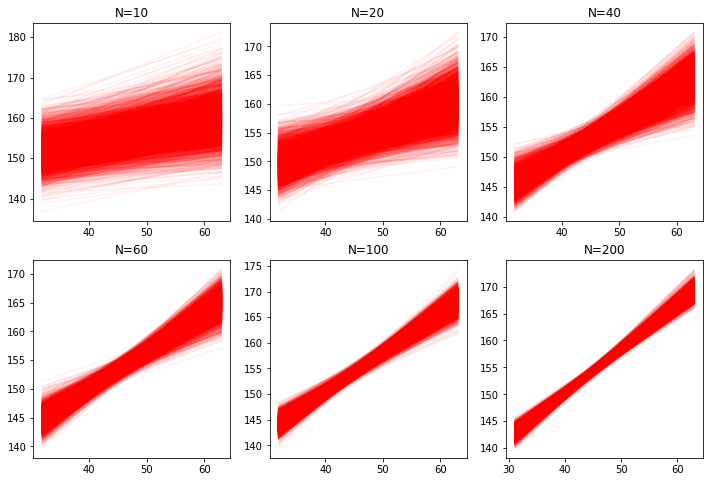

In [58]:
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
axes = axes.flatten()
for i, N in enumerate([10, 20, 40, 60, 100, 200]):
    data_fit = {'N': N, 'weights': d.weight.values[:N], 'heights': d.height.values[:N]}
    fit=model_2_fit.sample(data=data_fit,seed=28052020)
    df = fit.draws_pd()
    alpha = df['alpha'].values
    beta = df['beta'].values
    
    weight_range = np.linspace(data_fit['weights'].min(), data_fit['weights'].max(), N).reshape((N, 1))
    hhat = beta * weight_range + alpha
    extended_domain = np.ones((1, 4000)) * weight_range
    axes[i].plot(extended_domain, hhat, 'r', alpha=0.05)
    axes[i].set_title(f'{N=}')
plt.show()

As N increases the space of possible fits shrinks and the uncertainty is also getting smaller.

In [59]:
N = 50
data_fit = {'N': N, 'weights': d.weight.values[:N], 'heights': d.height.values[:N]}
fit=model_2_fit.sample(data=data_fit,seed=28052020)

INFO:cmdstanpy:CmdStan start processing
chain 1 |                                                                                                                                                                                     | 00:00 Status
chain 2 |                                                                                                                                                                                     | 00:00 Status

chain 3 |                                                                                                                                                                                     | 00:00 Status


chain 1 |████████▏                                                                                                                                                                            | 00:00 Status
chain 2 |████████▏                                                                                                                       

chain 4 |██████████████████████████████████████████████████████████████████████████                                                                          | 00:01 Iteration:  900 / 2000 [ 45%]  (Warmup)

chain 1 |██████████████████████████████████████████████████████████████████████████████████████▎                                                           | 00:01 Iteration: 1001 / 2000 [ 50%]  (Sampling)
chain 2 |██████████████████████████████████████████████████████████████████████████████████████▎                                                           | 00:01 Iteration: 1001 / 2000 [ 50%]  (Sampling)

chain 1 |████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 00:02 Iteration: 1100 / 2000 [ 55%]  (Sampling)
chain 2 |████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 00:02 Iteration: 1100

INFO:cmdstanpy:CmdStan done processing.


In [61]:
df = fit.draws_pd()

,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,alpha,sigma,beta,...,h_hat[41],h_hat[42],h_hat[43],h_hat[44],h_hat[45],h_hat[46],h_hat[47],h_hat[48],h_hat[49],h_hat[50]
0,-116.747,0.936448,0.165983,4.0,15.0,0.0,117.613,136.148,6.35775,0.390250,...,162.780,157.547,146.337,148.769,151.096,161.935,153.763,161.057,148.291,150.366
1,-117.885,0.592375,0.165983,3.0,11.0,0.0,121.695,132.391,6.52830,0.420847,...,155.289,151.057,156.085,146.998,153.355,154.375,144.325,148.344,154.985,149.157
2,-117.044,1.000000,0.165983,3.0,15.0,0.0,118.982,136.233,7.09360,0.392923,...,162.807,156.765,162.807,148.661,174.835,159.883,145.684,166.845,156.999,158.597
3,-115.194,0.829400,0.165983,4.0,19.0,0.0,119.097,130.990,5.55968,0.493890,...,149.021,158.486,159.047,154.532,145.028,159.649,147.787,154.920,160.543,154.552
4,-117.094,0.328912,0.165983,3.0,15.0,0.0,121.399,131.920,5.09075,0.463525,...,151.866,165.214,157.484,149.588,154.174,158.854,154.753,153.184,151.693,153.266


In [62]:
heights = df.loc[:, 'h_hat[1]':f'h_hat[{N}]'].values

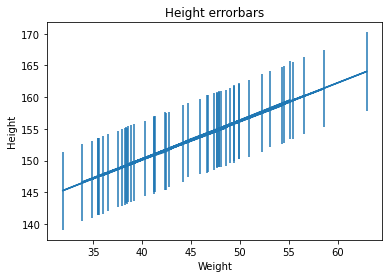

In [69]:
y = heights.mean(axis=0)
x = data_fit['weights']
yerr = heights.std(axis=0)

plt.errorbar(x, y, yerr)
plt.xlabel('Weight')
plt.ylabel('Height')
plt.title('Height errorbars')
plt.show()

INFO:cmdstanpy:CmdStan start processing
chain 1 |                                                                                                                                                                                     | 00:00 Status
chain 2 |                                                                                                                                                                                     | 00:00 Status

chain 3 |                                                                                                                                                                                     | 00:00 Status


chain 4 |                                                                                                                                                                                     | 00:00 Status

chain 3 |████████▏                                                                                                                      

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:CmdStan start processing
chain 1 |                                                                                                                                                                                     | 00:00 Status
chain 2 |                                                                                                                                                                                     | 00:00 Status

chain 3 |                                                                                                                                                                                     | 00:00 Status


chain 1 |████████▏                                                                                                                                                                            | 00:00 Status
chain 2 |████████▏                                                                                                                       

chain 1 |███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 00:02 Iteration: 1800 / 2000 [ 90%]  (Sampling)
chain 2 |███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 00:02 Iteration: 1800 / 2000 [ 90%]  (Sampling)

chain 3 |██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 00:02 Iteration: 1900 / 2000 [ 95%]  (Sampling)
chain 1 |█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 00:02 Sampling completed
chain 2 |█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|


INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:CmdStan start processing
chain 1 |                                                                                                                                                                                     | 00:00 Status
chain 2 |                                                                                                                                                                                     | 00:00 Status

chain 3 |                                                                                                                                                                                     | 00:00 Status


chain 1 |████████▏                                                                                                                                                                            | 00:00 Status
chain 2 |████████▏                                                                                                                       

chain 1 |███████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 00:01 Iteration: 1200 / 2000 [ 60%]  (Sampling)
chain 2 |████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 00:01 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 4 |████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 00:01 Iteration: 1100 / 2000 [ 55%]  (Sampling)

chain 1 |██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 00:02 Iteration: 1300 / 2000 [ 65%]  (Sampling)
chain 2 |███████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 00:02 Iteration: 120

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:CmdStan start processing
chain 1 |                                                                                                                                                                                     | 00:00 Status
chain 2 |                                                                                                                                                                                     | 00:00 Status

chain 3 |                                                                                                                                                                                     | 00:00 Status


chain 4 |                                                                                                                                                                                     | 00:00 Status
chain 1 |████████▏                                                                                                                       

chain 4 |██████████████████████████████████████████████████████████████████████████                                                                          | 00:02 Iteration:  900 / 2000 [ 45%]  (Warmup)

chain 1 |████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 00:02 Iteration: 1100 / 2000 [ 55%]  (Sampling)
chain 2 |████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 00:02 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 4 |██████████████████████████████████████████████████████████████████████████████████████▎                                                           | 00:02 Iteration: 1001 / 2000 [ 50%]  (Sampling)

chain 1 |███████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 00:02 Iteration: 12

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:CmdStan start processing
chain 1 |                                                                                                                                                                                     | 00:00 Status
chain 2 |                                                                                                                                                                                     | 00:00 Status

chain 3 |                                                                                                                                                                                     | 00:00 Status


chain 1 |████████▏                                                                                                                                                                            | 00:00 Status
chain 2 |████████▏                                                                                                                       

chain 3 |██████████████████████████████████████████████████████████████████████████                                                                          | 00:02 Iteration:  900 / 2000 [ 45%]  (Warmup)
chain 1 |██████████████████████████████████████████████████████████████████████████████████████▎                                                           | 00:02 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 4 |██████████████████████████████████████████████████████████████████████████████████████▎                                                           | 00:02 Iteration: 1001 / 2000 [ 50%]  (Sampling)

chain 3 |██████████████████████████████████████████████████████████████████████████████████████▎                                                           | 00:02 Iteration: 1001 / 2000 [ 50%]  (Sampling)
chain 1 |████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 00:03 Iteration: 110

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:CmdStan start processing
chain 1 |                                                                                                                                                                                     | 00:00 Status
chain 2 |                                                                                                                                                                                     | 00:00 Status

chain 3 |                                                                                                                                                                                     | 00:00 Status


chain 4 |                                                                                                                                                                                     | 00:00 Status

chain 1 |████████▏                                                                                                                      

chain 2 |██████████████████████████████████████████████████████████████████████████████████████▎                                                           | 00:04 Iteration: 1001 / 2000 [ 50%]  (Sampling)

chain 1 |██████████████████████████████████████████████████████████████████████████████████████▎                                                           | 00:04 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 4 |██████████████████████████████████████████████████████████████████████████████████████▎                                                           | 00:04 Iteration: 1001 / 2000 [ 50%]  (Sampling)
chain 2 |████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 00:05 Iteration: 1100 / 2000 [ 55%]  (Sampling)

chain 1 |████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 00:05 Iteration: 11


INFO:cmdstanpy:CmdStan done processing.


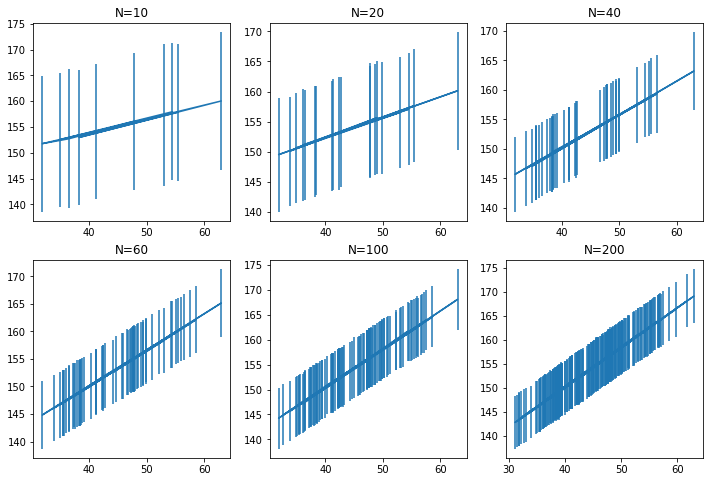

In [70]:
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
axes = axes.flatten()
for i, N in enumerate([10, 20, 40, 60, 100, 200]):
    data_fit = {'N': N, 'weights': d.weight.values[:N], 'heights': d.height.values[:N]}
    fit=model_2_fit.sample(data=data_fit,seed=28052020)
    df = fit.draws_pd()
    heights = df.loc[:, 'h_hat[1]':f'h_hat[{N}]'].values
    y = heights.mean(axis=0)
    x = data_fit['weights']
    yerr = heights.std(axis=0)

    axes[i].errorbar(x, y, yerr)
    axes[i].set_title(f'{N=}')
plt.show()

As N increases the errorbars tend to get smaller.

## Task 7. Extending the model

1. Center the weight data (substract mean vaule of weight from all values). Test how model works for such data. What is the interpretation of $\alpha$ in such case?
2. Using centered data modify your model with a second power of weight, select prior for its coefficient using prior predictive checks and after fitting check if model is still good.
3. Try to vectorize the model to avoid necessity of a for loop in the ```model``` block. 

INFO:cmdstanpy:CmdStan start processing
chain 1 |                                                                                                                                                                                     | 00:00 Status
chain 2 |                                                                                                                                                                                     | 00:00 Status

chain 3 |                                                                                                                                                                                     | 00:00 Status


chain 1 |████████▏                                                                                                                                                                            | 00:00 Status
chain 2 |████████▏                                                                                                                       

chain 4 |██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 00:02 Iteration: 1600 / 2000 [ 80%]  (Sampling)

chain 3 |███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 00:02 Iteration: 1800 / 2000 [ 90%]  (Sampling)
chain 1 |███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 00:02 Iteration: 1800 / 2000 [ 90%]  (Sampling)


chain 4 |████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 00:02 Iteration: 1700 / 2000 [ 85%]  (Sampling)
chain 2 |██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 00:02 Iteration: 190

INFO:cmdstanpy:CmdStan done processing.


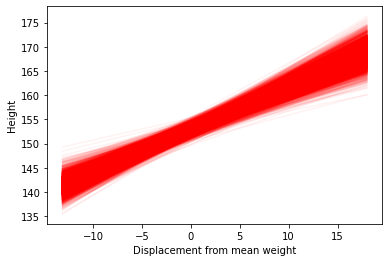

In [73]:
N = 50
data_fit = {'N': N, 'weights': d.c_weight.values[:N], 'heights': d.height.values[:N]}
fit=model_2_fit.sample(data=data_fit,seed=28052020)
df = fit.draws_pd()
alpha = df['alpha'].values
beta = df['beta'].values

weight_range = np.linspace(data_fit['weights'].min(), data_fit['weights'].max(), N).reshape((N, 1))
hhat = beta * weight_range + alpha
extended_domain = np.ones((1, 4000)) * weight_range
plt.plot(extended_domain, hhat, 'r', alpha=0.05)
plt.xlabel('Displacement from mean weight')
plt.ylabel('Height')
plt.show()

For centered data the model also works well. I'd say that $\alpha$ in this model describes the height of a person of mean weight, which stands for the intercept in the model.

In [78]:
%%writefile height_3_fit.stan

data {
    int<lower=0> N;
    vector[N] heights;
    vector[N] weights;
}

parameters {
    real<lower=0> alpha;
    real<lower=0> sigma;
    real<lower=0> beta1;
    real<lower=0> beta2;
}

transformed parameters {
    vector[N] mean;
    for (i in 1:N) {
      mean[i] = alpha + beta1 * weights[i] + beta2 * weights[i] * weights[i];
  }
}

model {
    alpha ~ normal(154, 7.7);
    sigma ~ normal(15, 3);
    beta1 ~ lognormal(0, 1);
    beta2 ~ lognormal(0, 1);
    
    for (i in 1:N) {
      heights[i] ~ normal(mean[i], sigma);
    }
}

generated quantities {
    vector[N] h_hat;
    for (i in 1:N) {
        h_hat[i] = normal_rng(mean[i], sigma);
    }
}

Overwriting height_3_fit.stan


In [80]:
model_3_fit=CmdStanModel(stan_file='height_3_fit.stan')

INFO:cmdstanpy:compiling stan file /home/height_3_fit.stan to exe file /home/height_3_fit
INFO:cmdstanpy:compiled model executable: /home/height_3_fit


In [81]:
N = 50
data_fit = {'N': N, 'weights': d.c_weight.values[:N], 'heights': d.height.values[:N]}
fit=model_3_fit.sample(data=data_fit,seed=28052020)
df = fit.draws_pd()
df.head()

INFO:cmdstanpy:CmdStan start processing
chain 1 |                                                                                                                                                                                     | 00:00 Status
chain 2 |                                                                                                                                                                                     | 00:00 Status

chain 3 |                                                                                                                                                                                     | 00:00 Status


chain 4 |                                                                                                                                                                                     | 00:00 Status
chain 1 |████████▏                                                                                                                       

chain 3 |████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 00:02 Iteration: 1400 / 2000 [ 70%]  (Sampling)


chain 1 |███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 00:02 Iteration: 1500 / 2000 [ 75%]  (Sampling)
chain 2 |███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 00:02 Iteration: 1500 / 2000 [ 75%]  (Sampling)

chain 3 |███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 00:02 Iteration: 1500 / 2000 [ 75%]  (Sampling)


chain 1 |██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 00:02 Iteration: 1

INFO:cmdstanpy:CmdStan done processing.


,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,alpha,sigma,beta1,...,h_hat[41],h_hat[42],h_hat[43],h_hat[44],h_hat[45],h_hat[46],h_hat[47],h_hat[48],h_hat[49],h_hat[50]
0,-113.807,0.954684,0.572656,3.0,7.0,0.0,114.456,151.028,5.46630,0.738854,...,156.063,176.976,159.358,153.631,149.248,169.090,155.590,152.138,157.908,149.146
1,-116.212,0.871638,0.572656,3.0,7.0,0.0,116.856,153.644,6.13027,0.891966,...,148.155,171.182,158.846,147.579,162.284,164.091,150.280,160.987,159.318,165.684
2,-114.363,0.943962,0.572656,3.0,7.0,0.0,118.216,150.856,4.83598,0.837093,...,150.578,173.372,152.771,149.067,157.827,163.252,165.148,141.903,152.265,154.616
3,-113.541,0.996421,0.572656,2.0,3.0,0.0,114.683,151.239,5.97075,0.800343,...,144.397,161.546,157.408,142.573,159.359,157.587,140.700,154.609,149.044,157.279
4,-115.362,0.774356,0.572656,2.0,3.0,0.0,116.020,150.566,6.26416,0.780233,...,139.921,167.152,148.138,157.935,159.879,150.711,159.607,154.658,154.208,157.371


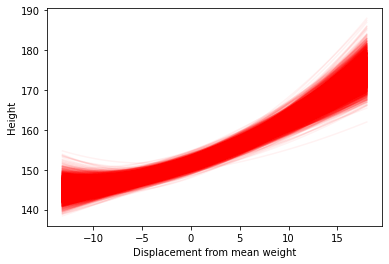

In [82]:
alpha = df['alpha'].values
beta1 = df['beta1'].values
beta2 = df['beta2'].values

weight_range = np.linspace(data_fit['weights'].min(), data_fit['weights'].max(), N).reshape((N, 1))
hhat = beta1 * weight_range + beta2 * weight_range ** 2 + alpha
extended_domain = np.ones((1, 4000)) * weight_range
plt.plot(extended_domain, hhat, 'r', alpha=0.05)
plt.xlabel('Displacement from mean weight')
plt.ylabel('Height')
plt.show()

Still makes sense. Might be a better fit for the whole population rather than only adults.

In [87]:
%%writefile height_3_fit_vectorized.stan

data {
    int<lower=0> N;
    vector[N] heights;
    vector[N] weights;
}

parameters {
    real<lower=0> alpha;
    real<lower=0> sigma;
    real<lower=0> beta1;
    real<lower=0> beta2;
}

transformed parameters {
    vector[N] mean;
    mean = alpha + beta1 * weights + beta2 * square(weights);
}

model {
    alpha ~ normal(154, 7.7);
    sigma ~ normal(15, 3);
    beta1 ~ lognormal(0, 1);
    beta2 ~ lognormal(0, 1);
    
    heights ~ normal(mean, sigma);
}

generated quantities {
    vector[N] h_hat;
    for (i in 1:N) {
        h_hat[i] = normal_rng(mean[i], sigma);
    }
}

Overwriting height_3_fit_vectorized.stan


In [88]:
model_3_fit_vectorized=CmdStanModel(stan_file='height_3_fit_vectorized.stan')

INFO:cmdstanpy:compiling stan file /home/height_3_fit_vectorized.stan to exe file /home/height_3_fit_vectorized
INFO:cmdstanpy:compiled model executable: /home/height_3_fit_vectorized


In [89]:
N = 50
data_fit = {'N': N, 'weights': d.c_weight.values[:N], 'heights': d.height.values[:N]}
fit=model_3_fit_vectorized.sample(data=data_fit,seed=28052020)
df = fit.draws_pd()
df.head()

INFO:cmdstanpy:CmdStan start processing
chain 1 |                                                                                                                                                                                     | 00:00 Status
chain 2 |                                                                                                                                                                                     | 00:00 Status

chain 3 |                                                                                                                                                                                     | 00:00 Status


chain 4 |                                                                                                                                                                                     | 00:00 Status
chain 1 |████████▏                                                                                                                       

INFO:cmdstanpy:CmdStan done processing.


,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,alpha,sigma,beta1,...,h_hat[41],h_hat[42],h_hat[43],h_hat[44],h_hat[45],h_hat[46],h_hat[47],h_hat[48],h_hat[49],h_hat[50]
0,-114.450,1.000000,0.610764,2.0,3.0,0.0,115.528,151.052,6.34552,0.851762,...,154.008,175.931,150.781,155.246,154.967,162.515,143.185,155.325,167.220,156.985
1,-115.575,0.970917,0.610764,3.0,7.0,0.0,116.294,149.978,5.85638,0.666783,...,143.399,167.313,159.540,147.908,151.725,154.575,149.725,152.605,156.364,149.375
2,-114.281,0.965929,0.610764,2.0,3.0,0.0,115.923,150.406,5.59294,0.747419,...,153.055,161.929,161.871,143.526,166.768,171.357,154.837,153.279,153.379,151.871
3,-113.817,0.910741,0.610764,2.0,7.0,0.0,115.070,151.046,5.39244,0.747188,...,147.337,166.240,144.335,148.505,163.773,159.872,148.907,151.596,155.229,152.065
4,-113.719,0.796440,0.610764,3.0,7.0,0.0,117.302,152.333,4.95056,0.867507,...,152.534,165.260,153.205,153.966,159.702,152.024,156.778,157.646,165.642,160.714


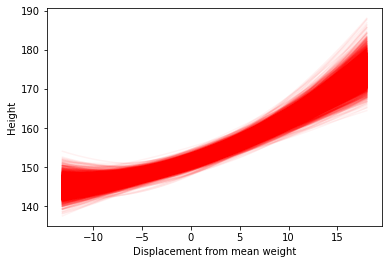

In [91]:
alpha = df['alpha'].values
beta1 = df['beta1'].values
beta2 = df['beta2'].values

weight_range = np.linspace(data_fit['weights'].min(), data_fit['weights'].max(), N).reshape((N, 1))
hhat = beta1 * weight_range + beta2 * weight_range ** 2 + alpha
extended_domain = np.ones((1, 4000)) * weight_range
plt.plot(extended_domain, hhat, 'r', alpha=0.05)
plt.xlabel('Displacement from mean weight')
plt.ylabel('Height')
plt.show()

The model block is for-loop-free and the code still works.